In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV



In [2]:
data_raw = pd.read_csv("marketing_campaign.csv", sep="\t")
data = data_raw.copy()

In [3]:
data = data.drop(columns=["ID", "Z_CostContact", "Z_Revenue"])
data['Income'] = data['Income'].fillna(data['Income'].median())

In [5]:
#defining bins and labels for age
age_bins = [17, 25, 45, 65, 100]  # cut-off points
age_labels = [
    "Young Impulsive/Luxury (18–25)",
    "Budget-Conscious (26–45)",
    "Affluent Mid-Lifers (46–65)",
    "Senior Premium Buyers (65+)"
]

In [6]:
# Apply binning
data['AgeGroup'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels)
le_age = LabelEncoder()
data['AgeGroup'] = le_age.fit_transform(data['AgeGroup'])

In [7]:
#binary encode
data['Is_In_Relationship'] = data['Marital_Status'].isin(['Married', 'Together']).astype(int)
data['Is_Single'] = data['Marital_Status'].isin(['Single','Divorced','Widow','Alone','Absurd','YOLO']).astype(int)


In [ ]:
spend_features = ["MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds"]
data["TotalSpend"] = data[spend_features].sum(axis=1)

In [9]:
data['Effective_Campaigns'] = (data['AcceptedCmp1'] + data['AcceptedCmp2'] + data['AcceptedCmp3'] + data['AcceptedCmp4'] + data['AcceptedCmp5'])

In [10]:
purchase_features = ["NumDealsPurchases","NumWebPurchases","NumCatalogPurchases","NumStorePurchases"]
data["TotalPurchases"] = data[purchase_features].sum(axis=1)

In [11]:
# binning education in 3 categories based on their expenditure and accepted campaigns
data['Education'] = data['Education'].replace(['PhD', 'Master', "Graduation"], "Graduated")
#Label encoding education
le_education = LabelEncoder()
data['Education_Encoded'] = le_education.fit_transform(data['Education'])

In [12]:
X = data[["AgeGroup", "Education_Encoded"]].copy()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

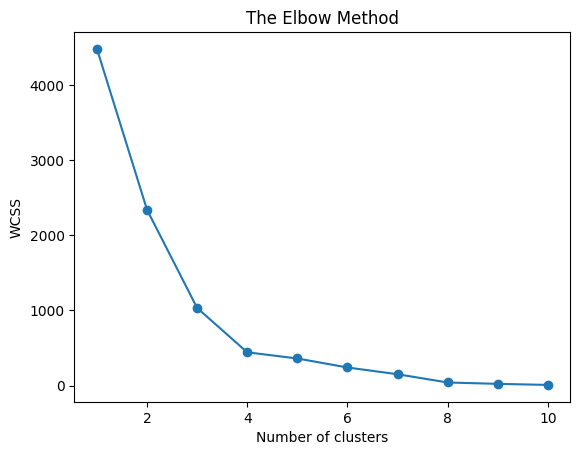

In [14]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss, marker="o")
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [13]:
kmeans = KMeans(n_clusters=4, init="k-means++", random_state=42)
labels = kmeans.fit_predict(scaled_data)

In [15]:
print("Silhouette Score (KMeans):", silhouette_score(scaled_data, labels))

Silhouette Score (KMeans): 0.9150078823831548


In [16]:
feature_groups = {
    "Demographics": ["AgeGroup", "Education_Encoded"],
    "Behavior": ["TotalSpend", "TotalPurchases", "Complain", "Response"],
    "Engagement": ["Effective_Campaigns", "Recency", "Complain"]
}

In [17]:
cluster_results = {}
for name, features in feature_groups.items():
    X = data[features]
    X_scaled = StandardScaler().fit_transform(X)

    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    data[f"{name}_Cluster"] = labels

    sil_score = silhouette_score(X_scaled, labels)

    profile = data.groupby(f"{name}_Cluster")[features].mean().round(2)
    edu_dist = (data.groupby(f"{name}_Cluster")["Education"]
                   .value_counts(normalize=True)
                   .unstack(fill_value=0).round(2))
    marital_dist = (data.groupby(f"{name}_Cluster")["Marital_Status"]
                      .value_counts(normalize=True)
                      .unstack(fill_value=0).round(2))

    cluster_results[name] = {
        "silhouette": sil_score,
        "profile": profile,
        "edu_dist": edu_dist,
        "marital_dist": marital_dist
    }

In [18]:
for view, results in cluster_results.items():
    print(f"\n=== {view.upper()} CLUSTERS ===")
    print("Silhouette:", round(results["silhouette"], 3))


=== DEMOGRAPHICS CLUSTERS ===
Silhouette: 0.915

=== BEHAVIOR CLUSTERS ===
Silhouette: 0.589

=== ENGAGEMENT CLUSTERS ===
Silhouette: 0.517


In [21]:
def create_robust_segment_assignment(data):
    # rule-based segments with balanced distribution

    income_high = data['Income'].quantile(0.65)      # Top 35% income
    income_mid = data['Income'].quantile(0.35)       # Above 35th percentile
    spend_high = data['TotalSpend'].quantile(0.65)   # Top 35% spending
    spend_mid = data['TotalSpend'].quantile(0.35)    # Above 35th percentile
    recency_active = data['Recency'].quantile(0.5)   # Bottom 50% (more recent)
    campaigns_active = data['Effective_Campaigns'].quantile(0.5)  # Above median
    purchases_active = data['TotalPurchases'].quantile(0.4)  # Above 40th percentile
    purchases_high = data['TotalPurchases'].quantile(0.7)  # Frequent buyers

    thresholds = {
        'income_high': income_high,
        'income_mid': income_mid,
        'spend_high': spend_high,
        'spend_mid': spend_mid,
        'recency_active': recency_active,
        'campaigns_active': campaigns_active,
        'purchases_active': purchases_active,
        'purchases_high': purchases_high
    }

    def assign_segment(row):
        # Premium Spenders: High income AND (High spending OR high engagement)
        if (row['TotalSpend'] > spend_high and (row['TotalPurchases'] > purchases_high or
             (row['Effective_Campaigns'] > campaigns_active or row['Recency'] <= recency_active))):
            return "Premium Spenders"

        # Value Seekers: Moderate+ income AND campaign responsive AND active
        elif ((row['Effective_Campaigns'] > 0 or row['Response'] == 1) and
              row['Recency'] <= recency_active):
            return "Value Seekers"

        # Budget-Conscious: Active customers (recent purchases) but not high spenders
        elif (row['Recency'] <= recency_active and
              row['TotalPurchases'] >= purchases_active and
              row['TotalSpend'] < spend_high):
            return "Budget-Conscious"

        # Dormant/Unengaged: Inactive customers (restrictive criteria)
        elif (row['Recency'] > data['Recency'].quantile(0.8) and  # Top 20% recency (very inactive)
              row['TotalPurchases'] < purchases_active and
              row['Effective_Campaigns'] == 0):
            return "Dormant/Unengaged"

        # Catch remaining customers - assign based on dominant characteristic
        else:
            if row['TotalSpend'] >= spend_mid:
                return "Budget-Conscious"  # Moderate spenders
            else:
                return "Value Seekers"  # Others who show some engagement
    return assign_segment, thresholds


# Use function without saving any files
segment_function, thresholds = create_robust_segment_assignment(data)
data['Rule_Based_Segment'] = data.apply(segment_function, axis=1)

# --- Print distribution of rule-based segments ---
print(" RULE-BASED SEGMENT DISTRIBUTION:")
print("=" * 45)
segment_counts = data['Rule_Based_Segment'].value_counts()
for segment, count in segment_counts.items():
    percentage = (count / len(data)) * 100
    print(f"{segment}: {count} customers ({percentage:.1f}%)")

print("\n THRESHOLDS:")
print("=" * 25)
print(f"High Income: ${thresholds['income_high']:,.0f} (65th percentile)")
print(f"Mid Income: ${thresholds['income_mid']:,.0f} (35th percentile)")
print(f"High Spend: ${thresholds['spend_high']:,.0f} (65th percentile)")
print(f"Active Recency: {thresholds['recency_active']:.0f} days (median)")


 RULE-BASED SEGMENT DISTRIBUTION:
Value Seekers: 711 customers (31.7%)
Budget-Conscious: 687 customers (30.7%)
Premium Spenders: 683 customers (30.5%)
Dormant/Unengaged: 159 customers (7.1%)

 THRESHOLDS:
High Income: $61,851 (65th percentile)
Mid Income: $41,653 (35th percentile)
High Spend: $790 (65th percentile)
Active Recency: 49 days (median)


In [25]:
features = [
    "Income", "TotalSpend", "TotalPurchases", "Effective_Campaigns",
    "Recency", "Age", "Family_Size", "Has_Children",
    "Is_In_Relationship", "Is_Single", "Education_Encoded"
]

X = data[features]
y = data["Rule_Based_Segment"]

print("Shape of Features:", X.shape)
print("Unique Segments:", y.unique())

Shape of Features: (2240, 11)
Unique Segments: ['Premium Spenders' 'Value Seekers' 'Budget-Conscious' 'Dormant/Unengaged']


In [26]:
segment_encoder = LabelEncoder()
y_encoded = segment_encoder.fit_transform(y)

print("Encoded Segments Mapping:")
for i, label in enumerate(segment_encoder.classes_):
    print(f"{i} -> {label}")

Encoded Segments Mapping:
0 -> Budget-Conscious
1 -> Dormant/Unengaged
2 -> Premium Spenders
3 -> Value Seekers


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
rf = RandomForestClassifier(
    n_estimators=200, random_state=42, class_weight="balanced"
)
rf.fit(X_train_scaled, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [33]:
y_pred = rf.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=segment_encoder.classes_))


Classification Report:
                    precision    recall  f1-score   support

 Budget-Conscious       0.94      0.98      0.96       137
Dormant/Unengaged       1.00      1.00      1.00        32
 Premium Spenders       1.00      1.00      1.00       137
    Value Seekers       0.98      0.94      0.96       142

         accuracy                           0.97       448
        macro avg       0.98      0.98      0.98       448
     weighted avg       0.97      0.97      0.97       448



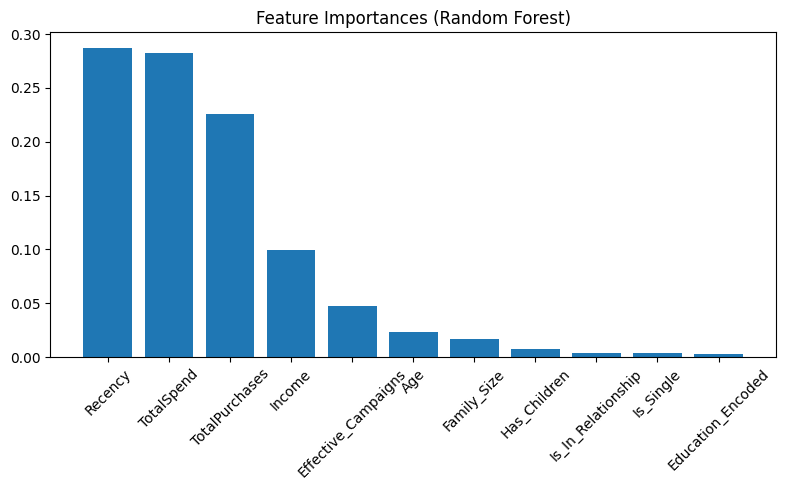

In [36]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

In [38]:
scores = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring="f1_weighted")
print("CV F1 scores:", scores)
print("Mean F1:", scores.mean())

CV F1 scores: [0.98328635 0.97210955 0.96922604 0.98882682 0.98600795]
Mean F1: 0.9798913419460433


Hyperparameter Tunning

In [40]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

search = RandomizedSearchCV(
    rf, param_distributions=param_grid, n_iter=10,
    scoring="f1_weighted", cv=3, random_state=42, n_jobs=-1
)
search.fit(X_train_scaled, y_train)
print("Best Params:", search.best_params_)

Best Params: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 30}


In [41]:
joblib.dump(scaler, "segmentation_scaler.pkl")
joblib.dump(rf, "segmentation_model.pkl")
joblib.dump(segment_encoder, "segment_encoder.pkl")

['segment_encoder.pkl']